In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
from tqdm import tqdm
import copy
from scipy.stats import linregress
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 10 
from scipy import stats
import random
import trackpy as tp

# Function Definitions

In [2]:
def compute_char(data_frame,vt):
    #compute: 
    # 1) speed 
    # 2) arrest coefficient i.e. time frames speend below vt
    # 3) mean speed

    for count,part in enumerate(data_frame.particle.unique()):
        df = data_frame.loc[data_frame.particle == part].sort_values(by=['frame']) 
        if len(df) > 3:
            dx = df.x.diff(1)
            dy = df.y.diff(1)
            dt = 3*df.frame.diff(1)
            vx= (dx/dt).to_numpy()
            vy= (dy/dt).to_numpy()
            v = np.sqrt(vx**2 + vy**2)
            real_v = v[1:-1]
            if(len(real_v)):
                a=len(real_v[real_v <= vt])/len(real_v)
            else: # zero length
                a=np.nan
            new_df={'particle':df.particle.iloc[0]*np.ones(len(real_v)),
                    'date':df.date.iloc[0] *np.ones(len(real_v)),
                    'v':real_v,
                    'frame_index':np.arange(0,len(real_v)),
                    'well':df.well.iloc[0] *np.ones(len(real_v)),
                    'arrest': a * np.ones(len(real_v)),'mv':np.mean(real_v) * np.ones(len(real_v)),
                    'x':df.x.iloc[1:-1],
                    'y': df.y.iloc[1:-1],
                    'frame': df.frame.iloc[1:-1],
                    'numf': df.shape[0]}
            if(count == 0):
                out=pandas.DataFrame(new_df)
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df)])
    return out 

def compute_char_well(data_frame):
    
    #characteristics per well:
    # 1) mean arrest coefficient
    # 2) num of cells
    # 3) mean speed

    for count,well in enumerate(data_frame.well.unique()):
        df = data_frame.loc[data_frame.well == well]
        coll_a = [df[df.particle == p].arrest.iloc[0] for p in df.particle.unique()]
        coll_v = [df[df.particle == p].mv.iloc[0] for p in df.particle.unique()]
        new_df={'well':df.well.iloc[0],'date':df.date.iloc[0],
                'arrest': np.nanmean(coll_a),
                'v': np.nanmean(coll_v),
                'cells': len(df.particle.unique())}
        if(count == 0):
            out=pandas.DataFrame(new_df, index=[0])
        else:  
            out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])
            
    return out 

def select_well_prop_per_part(data_frame_track):
    for count,part in enumerate(data_frame_track.particle.unique()):
        df = data_frame_track.loc[data_frame_track.particle == part]
        new_df={'well':df.well.iloc[0],'date':df.date.iloc[0],'particle':df.particle.iloc[0],'arrest':df.arrest.iloc[0],
                'mv':df.mv.iloc[0]}
        if(count == 0):
            out=pandas.DataFrame(new_df, index=[0])
        else:  
            out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])   
    return out

# Load data

In [5]:
data_on_spheroid = pandas.read_csv(r'Data\Trajectories_on_spheroids.csv')
tracks_wt_spheroid = data_on_spheroid.loc[data_on_spheroid.type == 'wt'].reset_index(drop = True)
tracks_apc_spheroid = data_on_spheroid.loc[data_on_spheroid.type == 'apc'].reset_index(drop = True)

In [6]:
data_on_matrigel = pandas.read_csv(r'Data\Trajectories_in_matrigel.csv')
tracks_wt_matrigel = data_on_matrigel.loc[data_on_matrigel.type == 'wt'].reset_index(drop = True)
tracks_apc_matrigel = data_on_matrigel.loc[data_on_matrigel.type == 'apc'].reset_index(drop = True)

In [7]:
vel_thresh = 1

np.seterr(divide='ignore', invalid='ignore')
data_apc_on=compute_char(tracks_apc_spheroid,vel_thresh)
data_wt_on=compute_char(tracks_wt_spheroid,vel_thresh)
np.seterr(divide='warn', invalid='warn')

np.seterr(divide='ignore', invalid='ignore')
data_apc_out=compute_char(tracks_apc_matrigel,vel_thresh)
data_wt_out=compute_char(tracks_wt_matrigel,vel_thresh)
np.seterr(divide='warn', invalid='warn')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# MSD on spheroids

In [ ]:
# Separate biological replicates
apc_on_221124 = tracks_apc_spheroid.loc[(tracks_apc_spheroid.date == 221124)]
wt_on_221124 = tracks_wt_spheroid.loc[(tracks_wt_spheroid.date == 221124)]
apc_on_220901 = tracks_apc_spheroid.loc[(tracks_apc_spheroid.date == 220901)]
wt_on_220901 = tracks_wt_spheroid.loc[(tracks_wt_spheroid.date == 220901)]
apc_on_220719 = tracks_apc_spheroid.loc[(tracks_apc_spheroid.date == 220719)]
wt_on_220719 = tracks_wt_spheroid.loc[(tracks_wt_spheroid.date == 220719)]

apc_on_tot = pandas.concat([apc_on_221124, apc_on_220901, apc_on_220719]).reset_index(drop = True)
wt_on_tot = pandas.concat([wt_on_221124, wt_on_220901, wt_on_220719]).reset_index(drop = True)

# Bootstrap data

N = 20

# WT cells
sample_wt_on = pandas.DataFrame()
nb_wt_on = 15
wt_on_221124_cell_nb = np.array(wt_on_221124.particle.unique())
wt_on_220901_cell_nb = np.array(wt_on_220901.particle.unique())
wt_on_220719_cell_nb = np.array(wt_on_220719.particle.unique())

for q in [i for i in range(100)]:
    list_wt_on = np.concatenate([random.sample(wt_on_221124_cell_nb.tolist(), nb_wt_on),
                                 random.sample(wt_on_220901_cell_nb.tolist(), nb_wt_on),
                                 random.sample(wt_on_220719_cell_nb.tolist(), nb_wt_on)])
    y = random.sample(list_wt_on.tolist(), N)
    selection = wt_on_tot.loc[wt_on_tot.particle.isin(y)]
    msd_wt = tp.emsd(selection, 1, 1/3)
    limit = 100
    msd_wt = pandas.DataFrame(msd_wt).reset_index()
    msd_wt = msd_wt.loc[msd_wt.lagt <= limit]
    msd_wt = msd_wt.set_index('lagt')
    msd_wt = msd_wt[['msd']]
    msd_wt = msd_wt.reset_index()
    
    sample_wt_on = pandas.concat([sample_wt_on, msd_wt])

# APC cells
sample_apc_on = pandas.DataFrame()
nb_apc_on = 15
apc_on_221124_cell_nb = np.array(apc_on_221124.particle.unique())
apc_on_220901_cell_nb = np.array(apc_on_220901.particle.unique())
apc_on_220719_cell_nb = np.array(apc_on_220719.particle.unique())

for q in [i for i in range(100)]:
    list_apc_on = np.concatenate([random.sample(apc_on_221124_cell_nb.tolist(), nb_apc_on),
                                  random.sample(apc_on_220901_cell_nb.tolist(), nb_apc_on),
                                  random.sample(apc_on_220719_cell_nb.tolist(), nb_apc_on)])
    y = random.sample(list_apc_on.tolist(), N)
    selection = apc_on_tot.loc[apc_on_tot.particle.isin(y)]
    msd_apc = tp.emsd(selection, 1, 1/3)
    limit = 100
    msd_apc = pandas.DataFrame(msd_apc).reset_index()
    msd_apc = msd_apc.loc[msd_apc.lagt <= limit]
    msd_apc = msd_apc.set_index('lagt')
    msd_apc = msd_apc[['msd']]
    msd_apc = msd_apc.reset_index()
    
    sample_apc_on = pandas.concat([sample_apc_on, msd_apc])
    
sample_wt_on['type'] = 'wt'
sample_wt_on.lagt = np.round(np.array(sample_wt_on.lagt),0).astype(int)
sample_apc_on['type'] = 'apc'
sample_apc_on.lagt = np.round(np.array(sample_apc_on.lagt),0).astype(int)
sample_tot = pandas.concat([sample_wt_on, sample_apc_on])
sample_tot.lagt = np.round(np.array(sample_tot.lagt),0).astype(int)

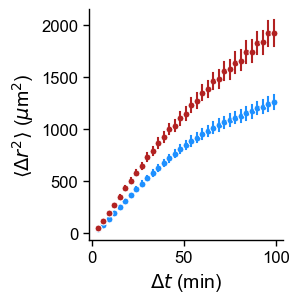

In [9]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (2.5,3))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)       
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
order = ['APC', 'WT']

sns.lineplot(data = sample_wt_on, x = 'lagt', y = 'msd', marker = 'o', color = 'dodgerblue', err_style="bars", linestyle='', markersize = 5, label = r'$CTRL$')
sns.lineplot(data = sample_apc_on, x = 'lagt', y = 'msd', marker = 'o', color = 'firebrick', err_style="bars", linestyle='', markersize = 5, label = r'$APC^{Min\ /+}$')

ax.set_xlabel(r'$\Delta t$ (min)', fontsize = 14)
ax.set_ylabel(r'$\langle \Delta  r^2 \rangle$ ($\mu$m$^2$)', fontsize = 14)
ax.get_legend().remove()
plt.show()

# Mean cell velocities and arrest coefficient per droplet

In [10]:
np.seterr(divide='ignore', invalid='ignore')
prop_apc_on=compute_char_well(data_apc_on)
prop_wt_on=compute_char_well(data_wt_on)

np.seterr(divide='warn', invalid='warn')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [11]:
well_wt_on=select_well_prop_per_part(data_wt_on)
well_apc_on=select_well_prop_per_part(data_apc_on)
well_wt_on['type']='wt'
well_apc_on['type']='apc'
collect_on = pandas.concat([well_wt_on,well_apc_on])
collect_on['on_sph'] = True
collect_on = collect_on.reset_index(drop = True)

well_wt_out=select_well_prop_per_part(data_wt_out)
well_apc_out=select_well_prop_per_part(data_apc_out)
well_wt_out['type']='wt'
well_apc_out['type']='apc'
collect_out = pandas.concat([well_wt_out,well_apc_out])
collect_out['on_sph'] = False
collect_out = collect_out.reset_index(drop = True)

collect = pandas.concat([collect_out, collect_on]).reset_index(drop = True)

select = collect[['well', 'date', 'mv', 'type', 'on_sph']]
Average_vel = select.groupby(['date', 'on_sph','type', 'well']).mean().reset_index()

collect['arrest_percent'] = 100*collect['arrest']
select = collect[['well', 'date', 'arrest_percent', 'type', 'on_sph']]
Arrest_coeff = select.groupby(['date', 'on_sph','type', 'well']).mean().reset_index()

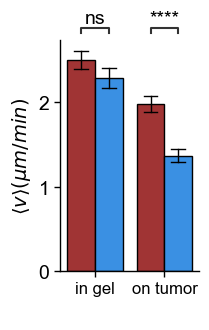

In [12]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (1.8,3))

order = [False, True]
hue_order = ['apc', 'wt']

# ax.set_ylim(0,60)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.barplot(
    x = 'on_sph',
    y = 'mv',
    hue = 'type',
    data=Average_vel,
    order = order,
    hue_order = hue_order,
    palette = ['firebrick','dodgerblue'],
    errorbar='se',
    errcolor='black',
    capsize=0.2,
    errwidth=1,
    color = 'r',
    lw = 1, 
    edgecolor="0"
)

add_stat_annotation(ax = ax,
                    data=Average_vel,   
                    x='on_sph',
                    y='mv',
                    hue = 'type',
                    order = order,
                    hue_order = hue_order,
                    box_pairs=[((True, 'wt'), (True, 'apc')), ((False, 'wt'), (False, 'apc'))],
                    test='t-test_welch', 
                    comparisons_correction=None, 
                    fontsize = 14,
                    text_format='star', loc='outside', verbose=0)

ax.set_xlabel(' ', fontsize = 14)
ax.set_ylabel(r'$\langle v \rangle (µm/min)$', fontsize = 14)
ax.get_legend().remove()
labels = ['in gel', 'on tumor']
ax.set_xticklabels(labels, fontsize = 12)
plt.show()

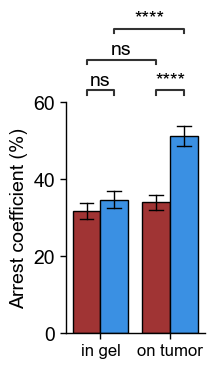

In [14]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (1.8,3))

order = [False, True]
hue_order = ['apc', 'wt']

ax.set_ylim(0,60)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

sns.barplot(
    x = 'on_sph',
    y = 'arrest_percent',
    hue = 'type',
    data=Arrest_coeff,
    order = order,
    hue_order = hue_order,
    palette = ['firebrick','dodgerblue'],
    errorbar='se',
    errcolor='black',
    capsize=0.2,
    errwidth=1,
    color = 'r',
    lw = 1, 
    edgecolor="0"
)

add_stat_annotation(ax = ax,
                    data=Arrest_coeff,   
                    x='on_sph',
                    y='arrest_percent',
                    hue = 'type',
                    order = order,
                    hue_order = hue_order,
                    box_pairs=[((True, 'apc'), (False, 'apc')),((True, 'wt'), (True, 'apc')),((False, 'wt'), (False, 'apc')),((True, 'wt'), (False, 'wt'))],
                    test='t-test_welch', 
                    comparisons_correction=None, 
                    fontsize = 14,
                    text_format='star', loc='outside', verbose=0)

ax.set_xlabel(' ', fontsize = 14)
ax.set_ylabel('Arrest coefficient (%)', fontsize = 14)
ax.get_legend().remove()
labels = ['in gel', 'on tumor']
ax.set_xticklabels(labels, fontsize = 12)
plt.show()

# Single cell velocity

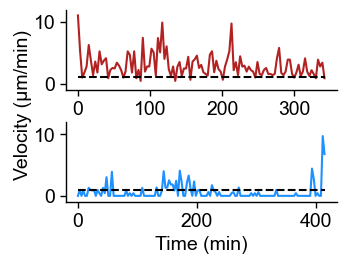

In [15]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(2,1, figsize = (3.5,2.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

for i in [0,1]:
    ax[i].set_ylim(-1,12)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(True)
    ax[i].tick_params(axis='x', labelsize=14, rotation=0)
    ax[i].tick_params(axis='y', labelsize=14)        
    ax[i].tick_params(width=1, length=4)
    for axis in ['bottom','left']:
        ax[i].spines[axis].set_linewidth(1)

particle_nb = 35
tracks_wt_no_nan = data_wt_on.dropna()
time = np.array(tracks_wt_no_nan.loc[tracks_wt_no_nan.particle == particle_nb, 'frame']*3)
time = time - np.min(time)
velocity = np.array(tracks_wt_no_nan.loc[tracks_wt_no_nan.particle == particle_nb, 'v'])
ax[1].plot(time, velocity, color = 'dodgerblue')
ax[1].plot(time, [1]*len(time), '--k')
ax[0].set_ylabel(' ', fontsize=14)
ax[0].set_xlabel(' ', fontsize=14)

particle_nb = 22
tracks_apc_no_nan = data_apc_on.dropna()
time = np.array(tracks_apc_no_nan.loc[tracks_apc_no_nan.particle == particle_nb, 'frame']*3)
time = time - np.min(time)
velocity = np.array(tracks_apc_no_nan.loc[tracks_apc_no_nan.particle == particle_nb, 'v'])
ax[0].plot(time, velocity, color = 'firebrick')
ax[0].plot(time, [1]*len(time), '--k')
ax[1].set_ylabel(' ', fontsize=14)
ax[1].set_xlabel('Time (min)', fontsize=14)

fig.supylabel('Velocity (µm/min)', fontsize = 14, ha = 'right', x = 0.03)
plt.show()